<a href="https://colab.research.google.com/github/ton-oliveira/projeto_eda_covid-/blob/main/projeto_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import lib & Funções

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from tensorflow.keras import layers
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
from tensorflow import keras
import plotly.express as px
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [5]:
def rename_columns(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

# Importar dados

In [6]:
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'
df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])

In [8]:
# print(df.head())
df.head()
# print(df.dtypes)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


# Rename Columns

In [11]:
df.columns = [rename_columns(col) for col in df.columns]
print(df.columns)

Index(['sno', 'observationdate', 'provincestate', 'countryregion',
       'lastupdate', 'confirmed', 'deaths', 'recovered'],
      dtype='object')


In [ ]:
# print(df.countryregion.unique())
# print(df.loc[df.countryregion == 'Brazil'])

# filtra Brazil

In [12]:
df_brazil = df.loc[
    (df.countryregion == 'Brazil') & (df.confirmed > 0)]

# Grafico casos Brasil

In [13]:
px.line(df_brazil, 'observationdate', 'confirmed', title='Casos confirmados no Brasil')

# Novos casos por dia

In [14]:
df_brazil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else df_brazil['confirmed'].iloc[x] - df_brazil['confirmed'].iloc[x-1], np.arange(df_brazil.shape[0])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# print(df_brazil)
df_brazil

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered,novoscasos
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,1.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0,17126.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0,13220.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0,7569.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0,14288.0


In [18]:
px.line(df_brazil, x='observationdate', y='novoscasos', title='Novos casos por dia')

# Grafico mortes

In [19]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_brazil.observationdate, y=df_brazil.deaths, name='Mortes',
               mode='lines+markers', line={'color':'red'})
)
# Layout
fig.update_layout(title='Mortes por Covid-19 no Brasil')
fig.show()

# Taxa de crescimento
Taxa_crescimento = (presente/passado)**(1/n) - 1

In [20]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data inicio for None, define como a primeira data disponivel
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd_to_datetime(data_inicio)
    
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # define os valores do presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o numero de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcular a taxa
    taxa = (presente / passado) ** (1 / n) -1
    
    return taxa * 100
                     

In [21]:
# Taxa de crescimento médio do COVID no Brasil em todo o período
taxa_crescimento(df_brazil, 'confirmed')

16.27183353112116

In [22]:
def taxa_crescimento_diaria(data,variable, data_inicio=None):
    
    # Se data inicio for None, define como a primeira data disponivel
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd_to_datetime(data_inicio)
    
    data_fim = data.observationdate.max()
    # Define o numero de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Taxa calculada de um dia para o outro
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x - 1]) / data[variable].iloc[x - 1],
        range(1, n+1)
        ))
    return np.array(taxas) * 100 
    

In [23]:
tx_dia = taxa_crescimento_diaria(df_brazil, 'confirmed')

In [24]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [25]:
primeiro_dia = df_brazil.observationdate.loc[df_brazil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, df_brazil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimeto de casos confirmados no Brasil')

# Predições

In [26]:
confirmados = df_brazil.confirmed
confirmados.index = df_brazil.observationdate
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64

In [27]:
res = seasonal_decompose(confirmados)

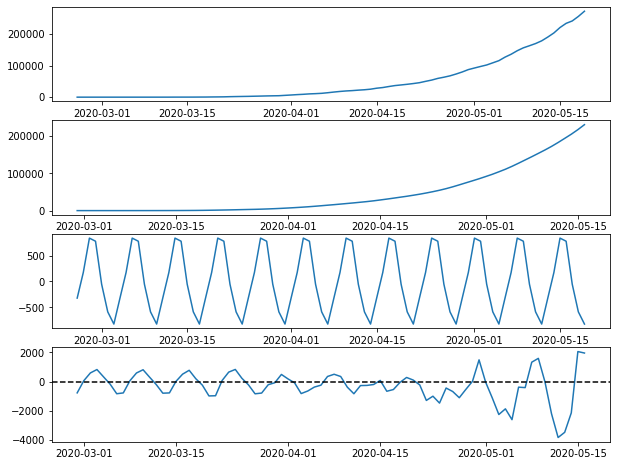

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))

# Observados
ax1.plot(res.observed)
# Tendência
ax2.plot(res.trend)
# Sassonalidade
ax3.plot(res.seasonal)
# Ruido, e marcar 
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle = 'dashed', c = 'black')

plt.show()

# Modelo Arima

In [36]:
# !pip install pmdarima

In [28]:
modelo = auto_arima(confirmados)

In [29]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observados'
))

fig.add_trace(go.Scatter(
    x=confirmados.index, y=modelo.predict_in_sample(), name='Preditos'
))
fig.add_trace(go.Scatter(
    x=pd.date_range('2020-05-20', '2020-06-20'), y=modelo.predict(31), name='Forecast'
))

fig.update_layout(title='Previsão de casos confirmados no Brasil para os próximos 30 dias')
fig.show()

# Modelo de Crescimento

In [3]:
# Vamos usar a biblioteca fbprophet

# !conda install -c conda-forge fbprophet -y
# !pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 178 kB 11.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640680 sha256=5b25255db81a058e8e202bc9eff758897b3eaeeac47d55b02452080298fda40a
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [30]:
# Preprocessamentos

train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# Renomeando colunas
train.rename(columns={'observationdate':'ds', 'confirmed': 'y'}, inplace=True)
test.rename(columns={'observationdate':'ds', 'confirmed': 'y'}, inplace=True)

#Definir o modelo de crescimento
profeta = Prophet(growth='logistic', changepoints=['2020-03-21', '2020-03-30', '2020-04-25',
                                                   '2020-05-03', '2020-05-10'])
# projeção de população Brasileira
pop = 211463256
train['cap'] = pop

# Treinar modelo
profeta.fit(train)

# Construir previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = profeta.predict(future_dates)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='predição'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()

In [57]:
# future_dates
df_train = pd.DataFrame(df_brazil, columns=['confirmed', 'recovered', 'novoscasos','deaths'])

train_X = df_train.drop('deaths', axis=1)
y_train = df_train['deaths']

# print(train_X.shape)

# Tensorflow

In [58]:
train_X.dtypes

confirmed     float64
recovered     float64
novoscasos    float64
dtype: object

In [60]:
model_tf = keras.Sequential([
      layers.Dense(units=512, activation='relu', input_shape=[3]),
      layers.Dense(units=512, activation='relu'),
      layers.Dense(units=512, activation='relu'),

      layers.Dense(1),
])

model_tf.compile(
    optimizer='adam',
    loss='mae',
)

history = model_tf.fit(
    train_X, y_train,
    batch_size=256,
    epochs=10,
)

Epoch 1/10
1/1 [==============================] - 1s 893ms/step - loss: 2896.3320
Epoch 2/10
1/1 [==============================] - 0s 27ms/step - loss: 9684.1074
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 6347.1177
Epoch 4/10
1/1 [==============================] - 0s 13ms/step - loss: 1062.5393
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 4297.3325
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 5271.2603
Epoch 7/10
1/1 [==============================] - 0s 13ms/step - loss: 4471.8721
Epoch 8/10
1/1 [==============================] - 0s 19ms/step - loss: 2680.0164
Epoch 9/10
1/1 [==============================] - 0s 19ms/step - loss: 297.4153
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 2569.9299


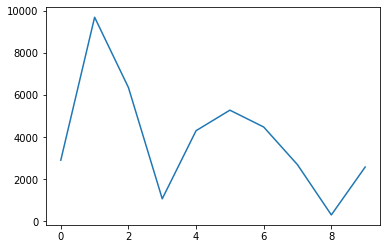

In [61]:
history_df = pd.DataFrame(history.history)
history_df['loss'].plot()